# Linear Regression 80/20 train/test split

Results for a 80/20 train/test split:
MSE: 3.8630306359863766
RMSE: 1.9654593956595432
R^2: 0.9237010885755159


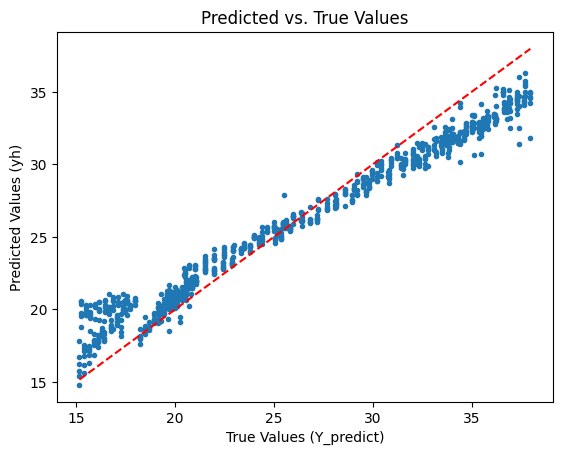

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
split = 80

# fetch dataset
df = pd.read_csv('parkinsons_updrs.csv')
pd.set_option('display.max_columns', None)

# data (as pandas dataframes)
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self,x,y):
        if x.ndim == 1:
            x = x[:,None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        self.w = np.linalg.lstsq(x,y)[0]
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

#Split Data
train_range = int(split / 100 * 5875) #5875 is the number of instances
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

#Fit and Predict
model = LinearRegression()
yh = model.fit(X_train,Y_train).predict(X_predict)

#Cost Function for prediction
mse_np = np.mean((Y_predict - yh)**2)
rmse_np = np.sqrt(mse_np)

def R2(y,yh):
    y = y.values
    y_mean = np.mean(y)
    ss_res = np.sum((y-yh)**2)
    ss_tot = np.sum((y-y_mean)**2)
    return 1 - ss_res / ss_tot

print(f'Results for a {split}/{100-split} train/test split:')
print(f"MSE: {mse_np}")
print(f"RMSE: {rmse_np}")
print(f"R^2: {R2(Y_predict, yh)}")

plt.plot(Y_predict,yh,'.')
plt.plot([Y_predict.min(), Y_predict.max()],[Y_predict.min(), Y_predict.max()], 'r--')
plt.xlabel('True Values (Y_predict)')
plt.ylabel('Predicted Values (yh)')
plt.title('Predicted vs. True Values')
plt.show()

# Logistic Regression (80/20 train/test split with learning rate 0.5)

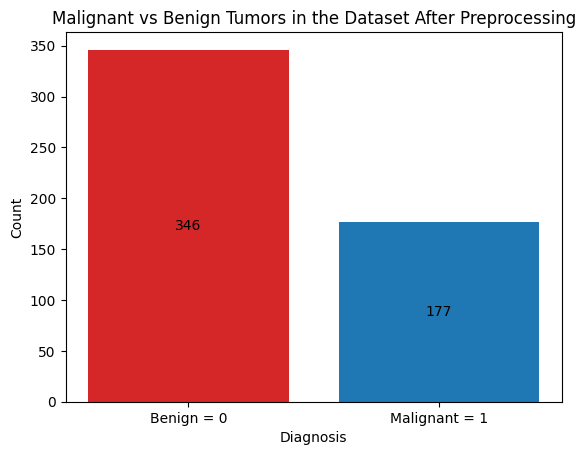

Results for a 80/20 train/test split with learning rate 0.5:
102/105 correct classifications (97.14% accuracy)


In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
import argparse
import seaborn as sns
from scipy import stats

#parse arguments
alpha = 0.5
split = 80

#set headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") #average value of the feature
    wdbcHeaders.insert(2*i+3, features[i]+"2") #standard error of the feature
    wdbcHeaders.insert(2*i+4, features[i]+"3") #worst/largest of the feature

breast_cancer_wisconsin_diagnostic = pd.read_csv('wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) #features
X = X.drop(X.iloc[:, 10:20], axis=1) #drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() #target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
#find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
#drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) #bar chart of diagnosis
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self,x,y):
        #Convert to numpy arrays if necessary
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        #gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iter:
            g = self.gradient(x,y)
            self.w = self.w - self.learning_rate * g
            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad

#calculate what % of points are correctly categorized (eg. y_predicted>0.5 vs. y_predicted<0.5)
def logistic_success_rate(y_predicted, y):
    N = len(y_predicted)
    y = np.array(y)
    yp = y_predicted.round() #round to either 0 or 1
    error = abs(yp-y) #if 0 then it was correctly predicted
    return round((N-error.sum())/N*100, 2)

def test_logistic_regression(x, y, split_percent, learning_rate):
    train_range = int(len(x) * split_percent / 100)

    # Split data manually
    X_train = x.iloc[:train_range]
    X_test = x.iloc[train_range:]
    y_train = y.iloc[:train_range]
    y_test = y.iloc[train_range:]

    model = LogisticRegression(learning_rate=learning_rate).fit(X_train, y_train)
    yh = model.predict(X_test)
    y = y_test['Diagnosis'].to_numpy()

    matching = (yh.round() == y).sum() #Number of correct classifications
    test_total = len(y_test)

    # Print results
    print(f'Results for a {split_percent}/{100-split_percent} train/test split with learning rate {alpha}:')
    print(f'{matching}/{test_total} correct classifications ({round(matching * 100 / test_total, 2)}% accuracy)')

#run the test using command line arguments
test_logistic_regression(X, Y, split, alpha)


**Stochastic Gradient Descent Linear Regression (80/20 train/test split and batch size 2350 with learning rate 1)**

Results for a 80/20 train/test split and batch size 2350 with learning rate 1:
MSE: 3.9884643354551366
RMSE: 1.9971140016171176
R^2: 0.9212236412997273


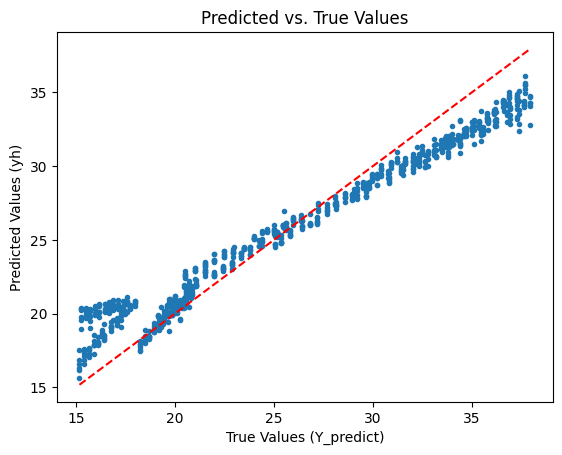

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
from scipy import stats

split = 80
alpha = 1
batch = 50
batch_size = 0

# fetch dataset
df = pd.read_csv('parkinsons_updrs.csv')
pd.set_option('display.max_columns', None)

# data (as pandas dataframes)
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        pass

    def fit(self,x,y):
        if hasattr(y,'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)

        #gradient descent
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100) #get batch size
        while np.linalg.norm(g) > self.epsilon and t <= self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = np.dot(x,self.w)
        grad = np.dot(x.T,(yh - y)) / N
        return grad

#Split Data
train_range = int(split / 100 * 5875) #5875 is the number of instances
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

#Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)

#Fit and Predict
model = LinearRegression(learning_rate=alpha)
yh = model.fit(X_train,Y_train).predict(X_predict)

#Cost Function for prediction
mse_np = np.mean((Y_predict.values.flatten() - yh)**2)
rmse_np = np.sqrt(mse_np)

def R2(y,yh):
    y = y.values.flatten()
    y_mean = np.mean(y)
    ss_res = np.sum((y-yh)**2)
    ss_tot = np.sum((y-y_mean)**2)
    return 1 - ss_res / ss_tot

print(f'Results for a {split}/{100-split} train/test split and batch size {batch_size} with learning rate {alpha}:')
print(f"MSE: {mse_np}")
print(f"RMSE: {rmse_np}")
print(f"R^2: {R2(Y_predict, yh)}")

plt.plot(Y_predict,yh,'.')
plt.plot([Y_predict.min(), Y_predict.max()],[Y_predict.min(), Y_predict.max()], 'r--')
plt.xlabel('True Values (Y_predict)')
plt.ylabel('Predicted Values (yh)')
plt.title('Predicted vs. True Values')
plt.show()


**Stochastic Gradient Descent Logistic Regression (80/20 train/test split and batch size 209 with learning rate 10)**

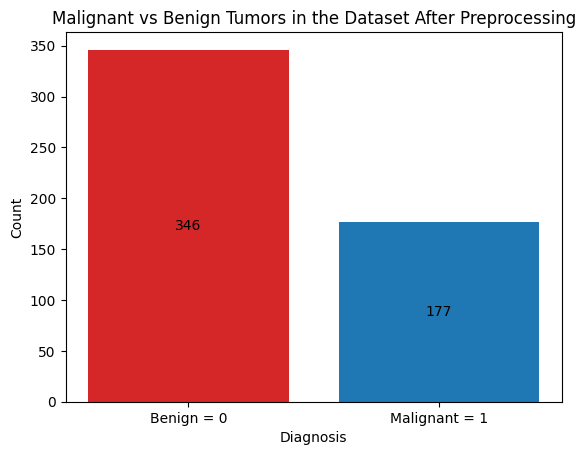

Results for a 80/20 train/test split and batch size 209 with learning rate 10:
95/105 correct classifications (90.48% accuracy)


In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
import argparse
from scipy import stats

split=80
alpha=10
batch=50
batch_size = 0

#set headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") #average value of the feature
    wdbcHeaders.insert(2*i+3, features[i]+"2") #standard error of the feature
    wdbcHeaders.insert(2*i+4, features[i]+"3") #worst/largest of the feature

breast_cancer_wisconsin_diagnostic = pd.read_csv('wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) #features
X = X.drop(X.iloc[:, 10:20], axis=1) #drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() #target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
#find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
#drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_mask = (z > 3).any(axis=1)
X = X[~outlier_mask]
Y = Y[~outlier_mask]

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) #bar chart of diagnosis
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self,x,y):
        #Convert to numpy arrays if necessary
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)
        #gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate /t * g
            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad

#calculate what % of points are correctly categorized (eg. y_predicted>0.5 vs. y_predicted<0.5)
def logistic_success_rate(y_predicted, y):
    N = len(y_predicted)
    y = np.array(y)
    yp = y_predicted.round() #round to either 0 or 1
    error = abs(yp-y) #if 0 then it was correctly predicted
    return round((N-error.sum())/N*100, 2)

def test_logistic_regression(x, y, split_percent, learning_rate):
    train_range = int(len(x) * split_percent / 100)

    # Split data manually
    X_train = x.iloc[:train_range]
    X_test = x.iloc[train_range:]
    y_train = y.iloc[:train_range]
    y_test = y.iloc[train_range:]

    model = LogisticRegression(learning_rate=learning_rate).fit(X_train, y_train)
    yh = model.predict(X_test)
    y = y_test['Diagnosis'].to_numpy()

    matching = (yh.round() == y).sum() #Number of correct classifications
    test_total = len(y_test)

    # Print results (only test data)
    print(f'Results for a {split}/{100-split} train/test split and batch size {batch_size} with learning rate {alpha}:')
    print(f'{matching}/{test_total} correct classifications ({round(matching * 100 / test_total, 2)}% accuracy)')

#run the test using command line arguments
test_logistic_regression(X, Y, split, alpha)